In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [187]:
# load the data
data = pd.read_csv('ANZTask2.csv')

In [188]:
# create dataframe
df = data

In [189]:
# clean the data using the technqiues used in task 1 to replace missing values and outliers
# drop columns with > 40% missing values as these won't be much use to the model
df = df.drop(['merchant_code', 'bpay_biller_code'], axis=1)

In [190]:
# fill missing values (except for those dropped)
# numerical data to be filled with mean, categorical data to be filled with mode
num_cols = ['age','amount', 'balance']
cat_cols = ['status', 'card_present_flag', 'account', 'currency', 'long_lat',
       'txn_description', 'merchant_id', 'first_name', 'date',
       'gender', 'merchant_suburb', 'merchant_state', 'extraction', 'transaction_id', 'country', 'customer_id',
       'merchant_long_lat', 'movement']

In [191]:
#  fill missing numerical values with mean
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

In [192]:
# fill missing categorical values with mode
df[cat_cols] = df[cat_cols].transform(lambda x: x.fillna(x.mode()[0]))

In [193]:
# find outliers using z score
z = np.abs(stats.zscore(df[num_cols]))

In [194]:
# set threshold at which outliers should be excluded
threshold = 3

In [195]:
# replace outliers with median value
median = df[num_cols].median()
df[num_cols] = np.where(z>threshold, median, df[num_cols])

# describe data after correcting outliers
df[num_cols].describe()

,age,amount,balance
count,12043.000000,12043.000000,12043.000000
mean,29.830856,103.662676,10539.170394
std,8.571904,281.779685,13306.808840
min,18.000000,0.100000,0.240000
25%,22.000000,16.000000,3158.585000
50%,28.000000,29.000000,6432.010000
75%,38.000000,48.880000,11525.535000
max,53.000000,1965.000000,108791.320000


In [196]:
# find salary for each customer ID
# select rows with salary data only using transaction description
df['txn_description'].value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

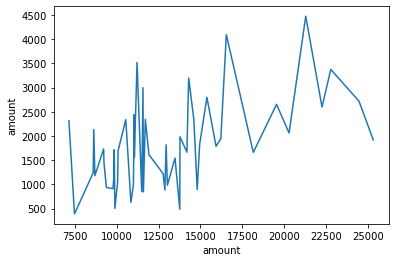

In [197]:
# investigate purchasing behaviour 

# sal_pos = df[df['txn_description']=='SALES-POS']
# pos = df[df['txn_description']=='POS']
# pay = df[df['txn_description']=='PAYMENT'] 
# int_ban = df[df['txn_description']=='INTER BANK']
# pay_sal = df[df['txn_description']=='PAY/SALARY']

df_sal_pos = sal_pos.groupby(['customer_id'])['amount'].sum().reset_index()
df_pos = pos.groupby(['customer_id'])['amount'].sum().reset_index()
df_pay = pay.groupby(['customer_id'])['amount'].sum().reset_index()
df_int_ban = int_ban.groupby(['customer_id'])['amount'].sum().reset_index()
df_pay_sal = pay_sal.groupby(['customer_id'])['amount'].sum().reset_index()

df_pay_sal_2 = df_pay_sal[(df_pay_sal['amount']>=4900)]
df_pay_sal_2.head()

# plot the variables and inspect charts for correlation
# ax_1 = sns.lineplot(x = df_pay_sal_2.amount, y = df_sal_pos.amount, data=df)
# ax_2 = sns.lineplot(x = df_pay_sal_2.amount, y = df_pos.amount, data=df)
ax_3 = sns.lineplot(x = df_pay_sal_2.amount, y = df_pay.amount, data=df)
# ax_4 = sns.lineplot(x = df_pay_sal_2.amount, y = df_int_ban.amount, data=df)

In [198]:
# plot suggests the PAYMENT correlates with PAY/SALARY
corr_df = pd.merge(df_pay_sal_2, df_pay, on='customer_id')
corr_df.rename(columns = {'amount_x':'df_pay_sal_2', 'amount_y':'df_pay'}, inplace=True)
corr_df.drop(['customer_id'], axis=1).corr()

,df_pay_sal_2,df_pay
df_pay_sal_2,1.000000,0.495838
df_pay,0.495838,1.000000


In [199]:
# for salary data, select rows which contain 'PAY/SALARY'
df_sal = df[df['txn_description'].str.contains('PAY/SALARY')]

In [200]:
# group by customer ID and sum amount to get salary amount for period August - October
sal_data = df_sal.groupby(['customer_id'])['amount'].sum().reset_index()
sal_data.rename(columns={'amount':'3mo_amount'}, inplace=True)

In [201]:
# multiply the salary for August, September, October by 4 to get annual salary
sal_data['annual_sal'] = sal_data['3mo_amount']*4

In [202]:
# summarise the salary data
sal_data.describe()

,3mo_amount,annual_sal
count,100.000000,100.000000
mean,6897.888700,27591.554800
std,7302.536586,29210.146342
min,58.000000,232.000000
25%,203.000000,812.000000
50%,7321.980000,29287.920000
75%,12382.582500,49530.330000
max,25305.410000,101221.640000


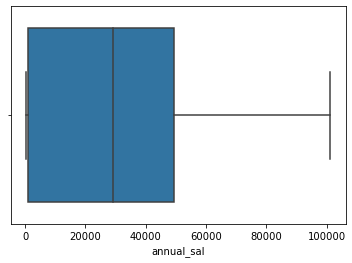

In [203]:
# insepct to find outliers
ax = sns.boxplot(sal_data['annual_sal'])

In [204]:
# data generally seems reasonable (although salary of 812 seems a little low)
# find outliers using z score
z = np.abs(stats.zscore(sal_data['annual_sal']))

In [205]:
# set threshold at which outliers should be excluded
threshold=3

# get max value of z to find outliers
z.max()

2.5334012058536106

array([[<AxesSubplot:title={'center':'3mo_amount'}>,
        <AxesSubplot:title={'center':'annual_sal'}>]], dtype=object)

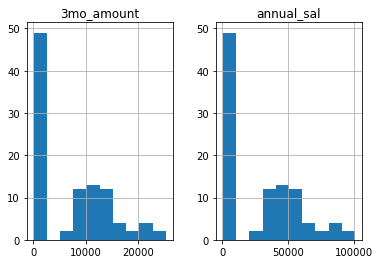

In [206]:
# no z values above 3, plot histogram to inspect visually
sal_data.hist()

array([[<AxesSubplot:title={'center':'3mo_amount'}>,
        <AxesSubplot:title={'center':'annual_sal'}>]], dtype=object)

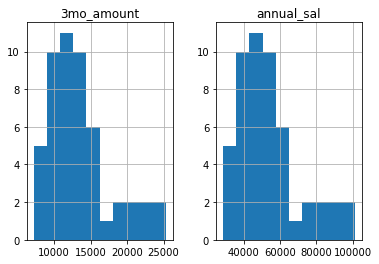

In [207]:
# histogram suggests the data is highly skewed by the presence of very low values
# which deviate from the general pattern of the data and distribution

# drop data which falls below 2000 as these values skew the data
sal_data = sal_data[sal_data['annual_sal']>=2000]
sal_data.hist()

In [208]:
# summarise amended salary data
sal_data.describe()
# this looks more reasonable

,3mo_amount,annual_sal
count,51.000000,51.000000
mean,13343.879804,53375.519216
std,4369.121301,17476.485205
min,7155.960000,28623.840000
25%,10074.170000,40296.680000
50%,12304.740000,49218.960000
75%,14878.415000,59513.660000
max,25305.410000,101221.640000


In [209]:
# join customer attributes to salary dataframe to create new dataframe for predictive model
# attributes which may help inform predictions include
# ['age', 'gender', 'long_lat', 'balance']
# returning the max will return the value for the customer (min or max doesn't matter as will return same value)

cust_data = df_sal.groupby(['customer_id'])[['age','gender','long_lat', 'balance']].max().reset_index()
cust_data.head()

,customer_id,age,gender,long_lat,balance
0,CUS-1005756958,53.0,F,153.03 -27.51,9310.03
1,CUS-1117979751,21.0,M,115.81 -31.82,18516.40
2,CUS-1140341822,28.0,M,144.97 -37.42,7658.48
3,CUS-1147642491,34.0,F,151.04 -33.77,15532.46
4,CUS-1196156254,34.0,F,138.52 -35.01,31350.50


In [212]:
# merge data frames
df_merge = pd.merge(sal_data, cust_data, on = 'customer_id')
df_merge.head()

,customer_id,3mo_amount,annual_sal,age,gender,long_lat,balance
0,CUS-1005756958,12616.11,50464.44,53.0,F,153.03 -27.51,9310.03
1,CUS-1140341822,11499.06,45996.24,28.0,M,144.97 -37.42,7658.48
2,CUS-1147642491,22248.07,88992.28,34.0,F,151.04 -33.77,15532.46
3,CUS-1233833708,7155.96,28623.84,44.0,M,145.18 -37.90,7218.79
4,CUS-1271030853,16214.10,64856.40,30.0,F,145.04 -37.85,9327.64


In [213]:
# add PAYMENT data to dataframe as earlier analysis showed this was correlated with PAY/SALARY
df_merge = pd.merge(df_merge, df_pay, on='customer_id')
df_merge.head()

,customer_id,3mo_amount,annual_sal,age,gender,long_lat,balance,amount
0,CUS-1005756958,12616.11,50464.44,53.0,F,153.03 -27.51,9310.03,1296.0
1,CUS-1140341822,11499.06,45996.24,28.0,M,144.97 -37.42,7658.48,852.0
2,CUS-1147642491,22248.07,88992.28,34.0,F,151.04 -33.77,15532.46,2597.0
3,CUS-1233833708,7155.96,28623.84,44.0,M,145.18 -37.90,7218.79,2313.0
4,CUS-1271030853,16214.10,64856.40,30.0,F,145.04 -37.85,9327.64,1941.0


In [214]:
df_merge.rename(columns={'amount':'PAYMENT'}, inplace=True)

,customer_id,3mo_amount,annual_sal,age,gender,long_lat,balance,PAYMENT
0,CUS-1005756958,12616.11,50464.44,53.0,F,153.03 -27.51,9310.03,1296.0
1,CUS-1140341822,11499.06,45996.24,28.0,M,144.97 -37.42,7658.48,852.0
2,CUS-1147642491,22248.07,88992.28,34.0,F,151.04 -33.77,15532.46,2597.0
3,CUS-1233833708,7155.96,28623.84,44.0,M,145.18 -37.90,7218.79,2313.0
4,CUS-1271030853,16214.10,64856.40,30.0,F,145.04 -37.85,9327.64,1941.0


In [219]:
# verify merge
print(sal_data[sal_data['customer_id'] == 'CUS-1140341822'], '\n\n', cust_data[cust_data['customer_id'] == 'CUS-1140341822'], '\n\n', df_pay[df_pay['customer_id'] == 'CUS-1140341822'])

      customer_id  3mo_amount  annual_sal
2  CUS-1140341822    11499.06    45996.24 

       customer_id   age gender       long_lat  balance
2  CUS-1140341822  28.0      M  144.97 -37.42  7658.48 

       customer_id  amount
2  CUS-1140341822   852.0


In [222]:
# Prepare data for modelling by dropping columns that won't be used
# drop 3mo_amount column
df_merge = df_merge.drop(['3mo_amount'],axis=1)

# also drop customer_id column as customer_id is unique and won't correlate with salary
df_merge = df_merge.drop(['customer_id'], axis=1)

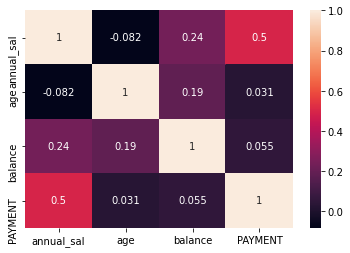

In [223]:
# check correlation
ax = sns.heatmap(df_merge.corr(), annot=True)

In [224]:
# get dummy data to autoencode categorical variables
df_merge = pd.get_dummies(df_merge)
df_merge.head()

,annual_sal,age,balance,PAYMENT,gender_F,gender_M,long_lat_114.62 -28.80,long_lat_115.72 -32.28,long_lat_115.74 -31.72,long_lat_115.78 -31.90,...,long_lat_151.18 -33.80,long_lat_151.23 -33.94,long_lat_151.27 -33.85,long_lat_151.27 -33.90,long_lat_153.03 -27.51,long_lat_153.05 -27.61,long_lat_153.09 -27.48,long_lat_153.10 -27.66,long_lat_153.32 -27.93,long_lat_153.41 -27.95
0,50464.44,53.0,9310.03,1296.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,45996.24,28.0,7658.48,852.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,88992.28,34.0,15532.46,2597.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,28623.84,44.0,7218.79,2313.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,64856.40,30.0,9327.64,1941.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Building

In [225]:
# set target variable y and features X
y = df_merge['annual_sal']
X = df_merge.drop(['annual_sal'],axis=1)

In [226]:
# generate train and test variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## Linear Model

In [227]:
# create and fit linear model to predict annual salary
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [228]:
# check score using neg_mean_absolute_error
lr_score = np.mean(cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=7))
lr_score

-12017.524231354038

In [229]:
# generate predictions
pred_lr = lr.predict(X_test)

In [230]:
# test error on prediction against y_test
print('mae_lr = ', mean_absolute_error(y_test, pred_lr))

mae_lr =  17888.572943003066


## Decision Tree (Random Forest) Model

In [231]:
#  create and fit Random Forest model to predict annual salary
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [232]:
# check score using neg_mean_absolute_error
rf_score = np.mean(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=7))
rf_score

-12343.203182857136

In [233]:
# generate prediction
pred_rf = rf.predict(X_test)

In [234]:
# test error on prediction against y_test
print('mae_rf = ', mean_absolute_error(y_test, pred_rf))

mae_rf =  14340.115999999996


## Hyperparameter Tuning

In [235]:
# tune random forest using Gridserachcv
# set parameters for tuning
parameters = {'n_estimators': range(10, 300, 10), 'criterion': ('mse', 'mae'), 'max_features': ('auto', 'sqrt', 'log2')}

In [245]:
# create and fit GridSearchCV  
gs = GridSearchCV(rf, parameters, scoring='neg_mean_absolute_error', cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'criterion': ('mse', 'mae'),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(10, 300, 10)},
             scoring='neg_mean_absolute_error')

In [246]:
# print best_estimator_ which shows parameters of tuned model 
gs.best_estimator_

RandomForestRegressor(criterion='mae', max_features='sqrt', n_estimators=60)

In [247]:
# generate prediction
pred_gs = gs.predict(X_test)

In [248]:
# test error on prediction against y_test
print('mae_gs=', mean_absolute_error(y_test, pred_rf))

mae_gs= 14340.115999999996
